In [233]:
from pyspark.ml.recommendation import ALS
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pyspark.ml.pipeline import PipelineModel
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [234]:
# import model file, set rank
model = PipelineModel.load("model_rmse_10")
rank = 10

In [235]:
# lists
matrix_u = model.stages[-1].userFactors.orderBy("id").collect()
matrix_vt = model.stages[-1].itemFactors.orderBy("id").collect()

In [236]:
matrixVT = np.zeros((len(matrix_vt),rank))
idxVT = np.zeros(len(matrix_vt))
matrixU = np.zeros((len(matrix_u),rank))
idxU = np.zeros(len(matrix_u))

In [237]:
# turn our lists into arrays
for i in range(len(matrix_vt)):
    for j in range(rank):
        matrixVT[i][j] = matrix_vt[i][1][j]
        idxVT[i] = matrix_vt[i][0]
        
for i in range(len(matrix_u)):
    for j in range(rank):
        matrixU[i][j] = matrix_u[i][1][j]
        idxU[i] = matrix_u[i][0]


In [238]:
# pandas 
df_vt = pd.DataFrame(data=matrixVT, index=idxVT)
df_u = pd.DataFrame(data=matrixU, index=idxU)

In [239]:
df_vt.shape

(163206, 10)

In [240]:
# downsample users and items
df_vt_samp = df_vt.sample(frac=.01,random_state=8)
idx_vt_samp = df_vt_samp.index.values

df_u_samp = df_u.sample(frac=.01,random_state=10)
idx_u_samp = df_u_samp.index.values

In [241]:
# import metadata 
metadata_item = pq.read_table("metadata_transform.parquet")
metadata_item_df = metadata_item.to_pandas()

metadata_user = pq.read_table("user_transform.parquet")
metadata_user_df = metadata_user.to_pandas()

metadata_tag = pq.read_table("tag_transform.parquet")
metadata_tag_df = metadata_tag.to_pandas().dropna()

#change nan to other
# metadata_tag_df = metadata_tag_df.fillna('other')

In [254]:
# first set of perplexity values to visualize
perplexity = np.arange(5,26,10)

# second set of perplexity values to visualize
perplexity2 = np.arange(30,51,10)

# third set of perplexity values to visualize
perplexity3 = np.arange(0,6,2)

bin_num = 20

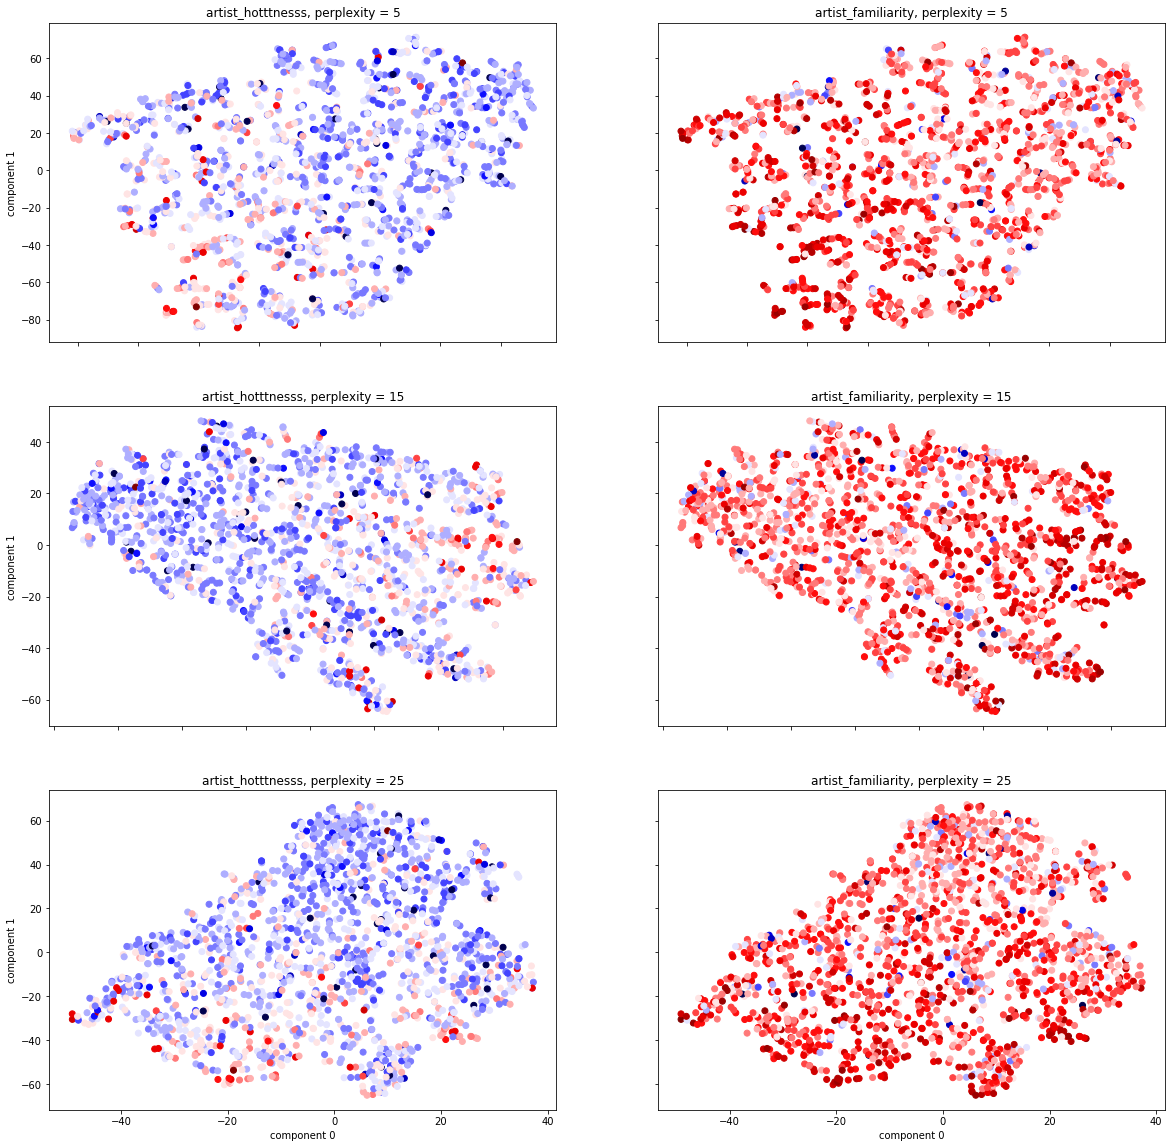

In [255]:
# item t-sne plots perplexity = 5,15,25

fig, axs = plt.subplots(3, 2, figsize=(20,20))

for i, row in zip(perplexity, range(3)):
    
    # fit/transform t-sne at different perplexity values
    arr_embedded = TSNE(n_components=2,perplexity=i,random_state=18).fit_transform(df_vt_samp)
    embedded_df = pd.DataFrame(arr_embedded,index=idx_vt_samp)
    embedded_df['track_index'] = embedded_df.index
    embedded_df = embedded_df.join(metadata_item_df.set_index('track_index'),on='track_index')
    
    # artist hotness t-sne plots at different perplexity values
    axs[row, 0].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                                  c=embedded_df['artist_hotttnesss'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 0].set_title('artist_hotttnesss, perplexity = {}'.format(i))
    # artist familiarity t-sne plots at different perplexity values
    axs[row, 1].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                        c=embedded_df['artist_familiarity'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 1].set_title('artist_familiarity, perplexity = {}'.format(i))

for ax in axs.flat:
    ax.set(xlabel='component 0', ylabel='component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

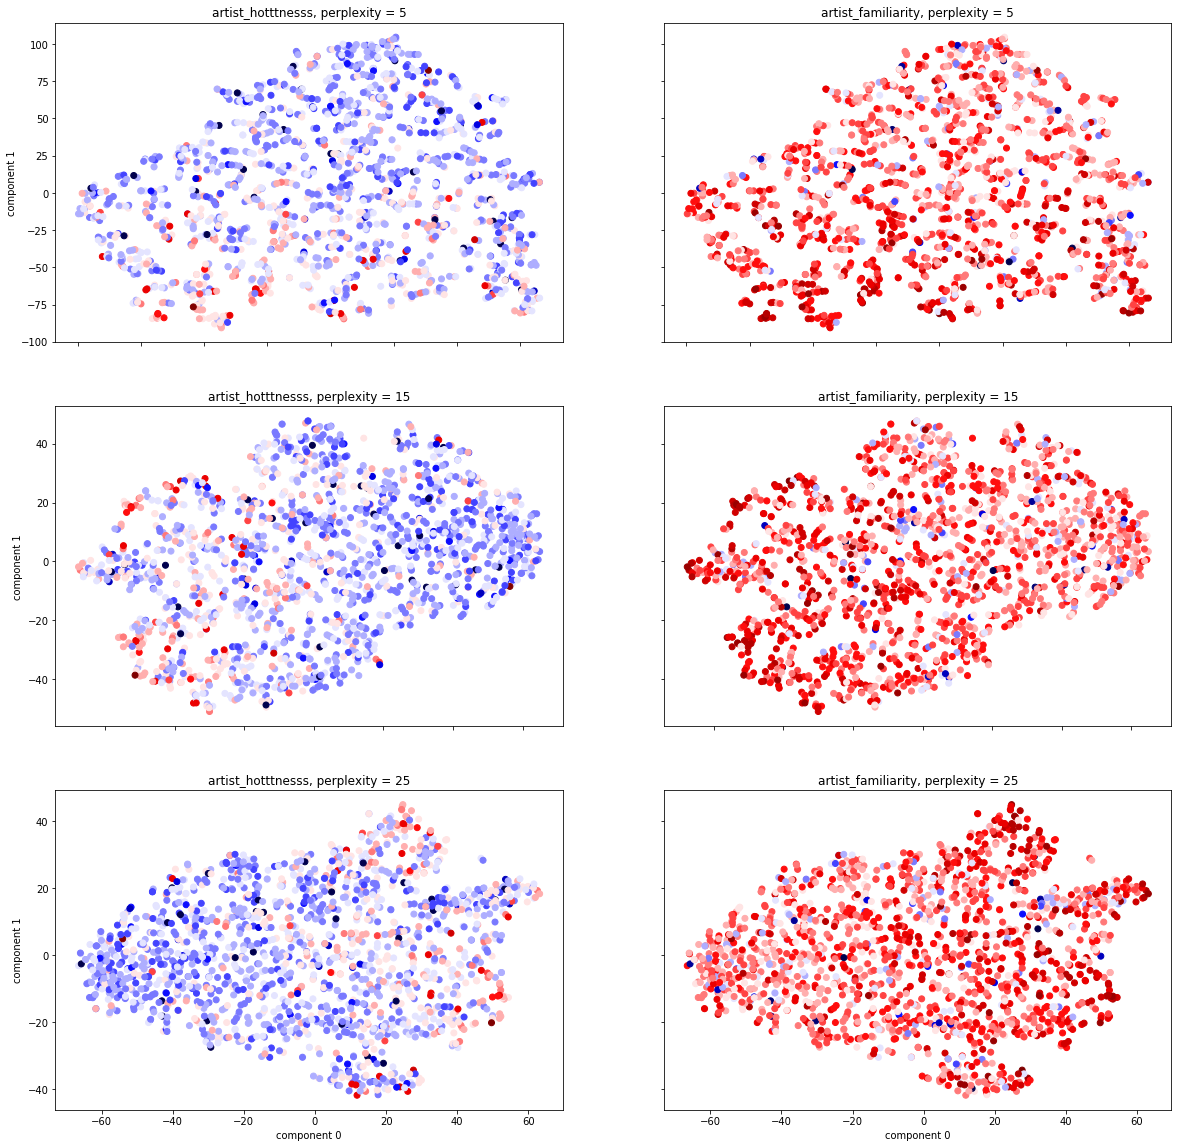

In [256]:
# item t-sne plots perplexity = 30,40,50

fig, axs = plt.subplots(3, 2, figsize=(20,20))



for i, row in zip(perplexity, range(3)):
    
    # fit/transform t-sne at different perplexity values
    arr_embedded = TSNE(n_components=2,perplexity=i,random_state=12).fit_transform(df_vt_samp)
    embedded_df = pd.DataFrame(arr_embedded,index=idx_vt_samp)
    embedded_df['track_index'] = embedded_df.index
    embedded_df = embedded_df.join(metadata_item_df.set_index('track_index'),on='track_index')
    
    # artist hotness t-sne plots at different perplexity values
    axs[row, 0].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                                  c=embedded_df['artist_hotttnesss'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 0].set_title('artist_hotttnesss, perplexity = {}'.format(i))
    # artist familiarity t-sne plots at different perplexity values
    axs[row, 1].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                        c=embedded_df['artist_familiarity'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 1].set_title('artist_familiarity, perplexity = {}'.format(i))

for ax in axs.flat:
    ax.set(xlabel='component 0', ylabel='component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

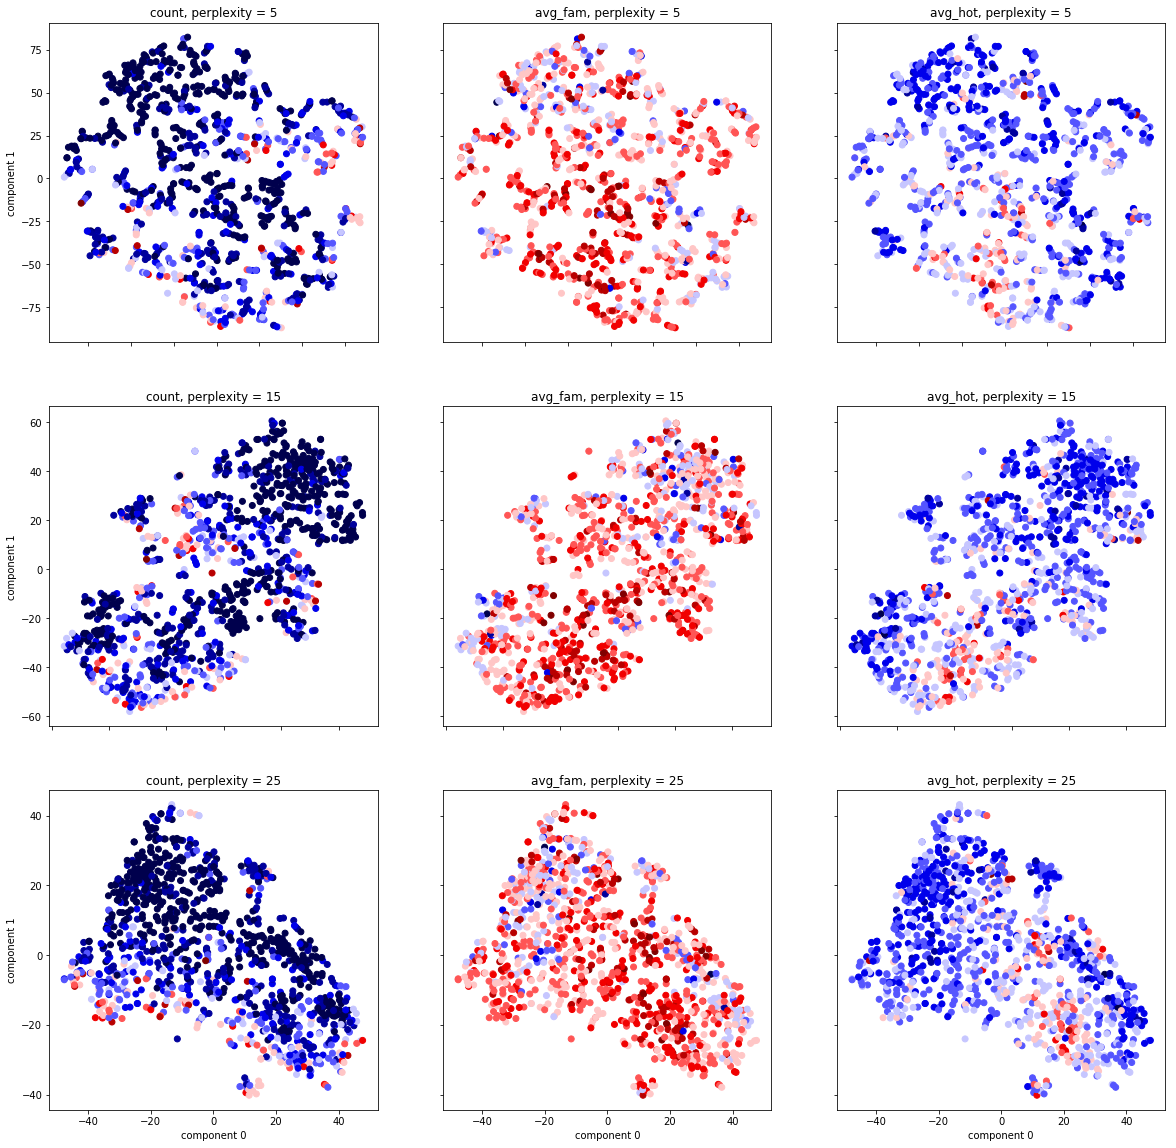

In [245]:
# user t-sne plots for perplexity = 5,15,25

fig, axs = plt.subplots(3, 3, figsize=(20,20))

for i, row in zip(perplexity, range(3)):
    
    # fit/transform t-sne at different perplexity values
    arr_embedded = TSNE(n_components=2,perplexity=i,random_state=3).fit_transform(df_u_samp)
    embedded_df = pd.DataFrame(arr_embedded,index=idx_u_samp)
    embedded_df['user_index'] = embedded_df.index
    embedded_df = embedded_df.join(metadata_user_df.set_index('user_index'),on='user_index')
    
    # count t-sne plots at different perplexity values
    axs[row, 0].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                                  c=embedded_df['count'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 0].set_title('count, perplexity = {}'.format(i))
    
    #  avg_fam t-sne plots at different perplexity values
    axs[row, 1].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                        c=embedded_df['avg_fam'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 1].set_title('avg_fam, perplexity = {}'.format(i))
    
    #  avg_hot t-sne plots at different perplexity values
    axs[row, 2].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                        c=embedded_df['avg_hot'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 2].set_title('avg_hot, perplexity = {}'.format(i))

for ax in axs.flat:
    ax.set(xlabel='component 0', ylabel='component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

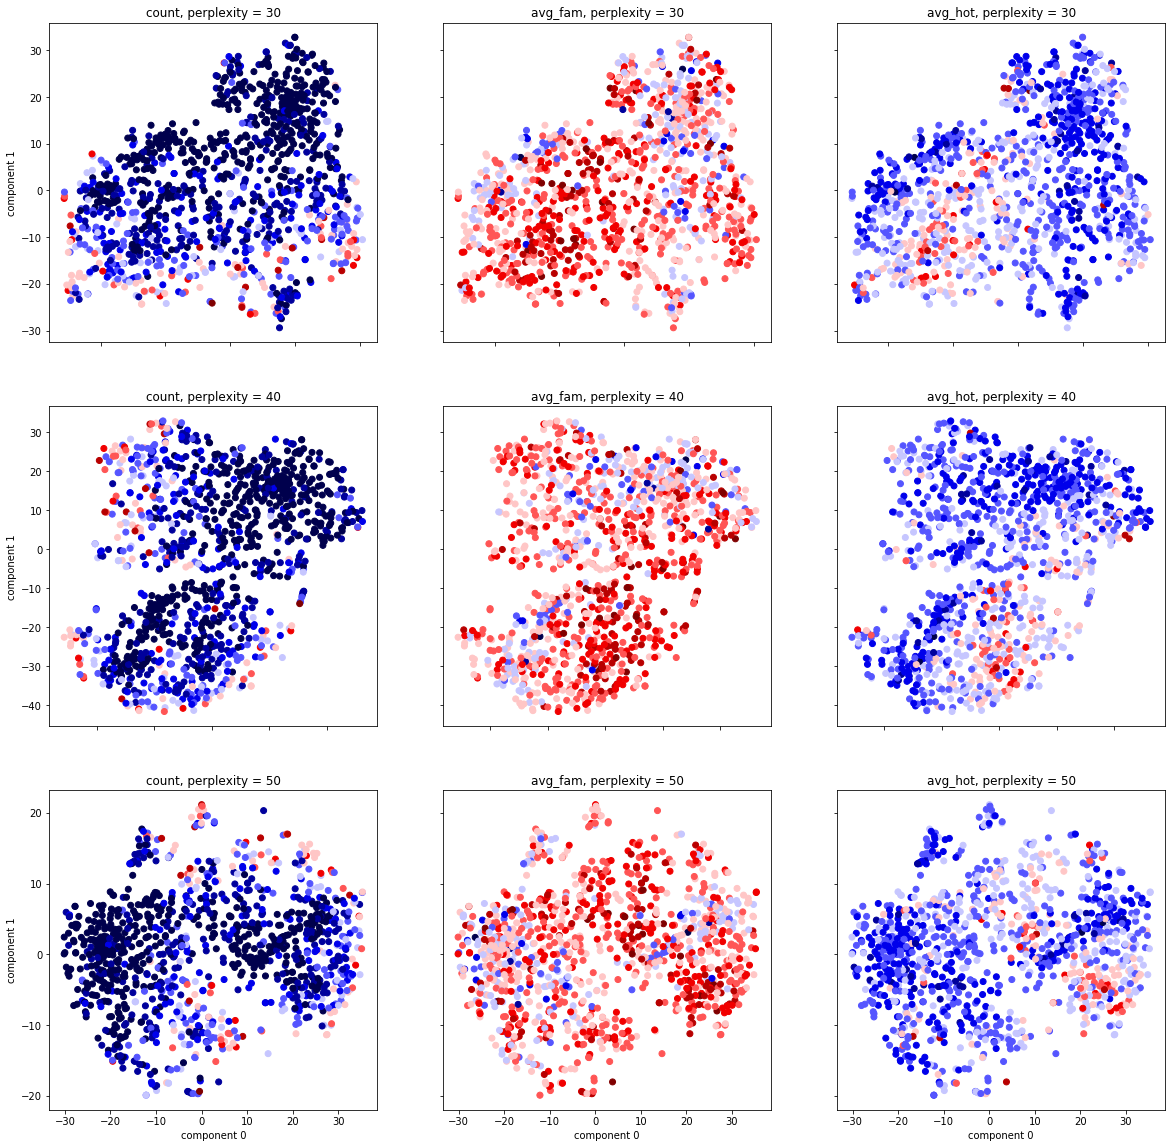

In [246]:
# user t-sne plots for perplexity = 30,40,50

fig, axs = plt.subplots(3, 3, figsize=(20,20))

for i, row in zip(perplexity2, range(3)):
    
    # fit/transform t-sne at different perplexity values
    arr_embedded = TSNE(n_components=2,perplexity=i,random_state=72).fit_transform(df_u_samp)
    embedded_df = pd.DataFrame(arr_embedded,index=idx_u_samp)
    embedded_df['user_index'] = embedded_df.index
    embedded_df = embedded_df.join(metadata_user_df.set_index('user_index'),on='user_index')
    
    # count t-sne plots at different perplexity values
    axs[row, 0].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                                  c=embedded_df['count'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 0].set_title('count, perplexity = {}'.format(i))
    
    #  avg_fam t-sne plots at different perplexity values
    axs[row, 1].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                        c=embedded_df['avg_fam'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 1].set_title('avg_fam, perplexity = {}'.format(i))
    
    #  avg_hot t-sne plots at different perplexity values
    axs[row, 2].scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                        c=embedded_df['avg_hot'].values, cmap=plt.cm.get_cmap("seismic", bin_num))
    axs[row, 2].set_title('avg_hot, perplexity = {}'.format(i))

for ax in axs.flat:
    ax.set(xlabel='component 0', ylabel='component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

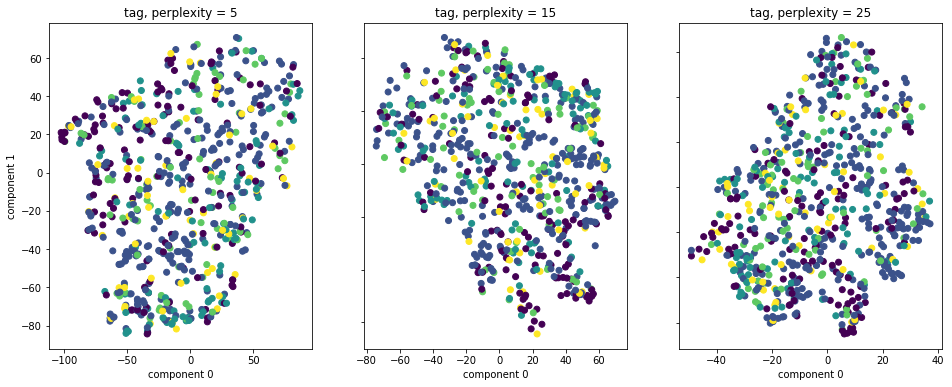

In [247]:
## item t-sne plots perplexity = 5,15,25

fig, axs = plt.subplots(1,3,figsize=(16,6))

for i, col in zip(perplexity, range(3)):
    
    # fit/transform t-sne at different perplexity values
    arr_embedded = TSNE(n_components=2,perplexity=i,random_state=18).fit_transform(df_vt_samp)
    embedded_df = pd.DataFrame(arr_embedded,index=idx_vt_samp)
    embedded_df['track_index'] = embedded_df.index
    embedded_df = embedded_df.join(metadata_tag_df.set_index('track_index'),on='track_index')
    embedded_df = embedded_df.loc[~embedded_df.index.duplicated(keep='first')]
    embedded_df = embedded_df.dropna()
    
    embedded_df['tag'] = embedded_df['tag'].map({'pop':1, 'rock':2, 'electronic':3, 'indie':4, 'alternative':5})
    
    # tag t-sne plots at different perplexity values
    n = embedded_df['tag'].nunique()
    axs[col].scatter(x=embedded_df[0].values, y=embedded_df[1].values, c=embedded_df['tag'].values,label=embedded_df['tag'].unique())
    axs[col].set_title('tag, perplexity = {}'.format(i))


for ax in axs.flat:
    ax.set(xlabel='component 0', ylabel='component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

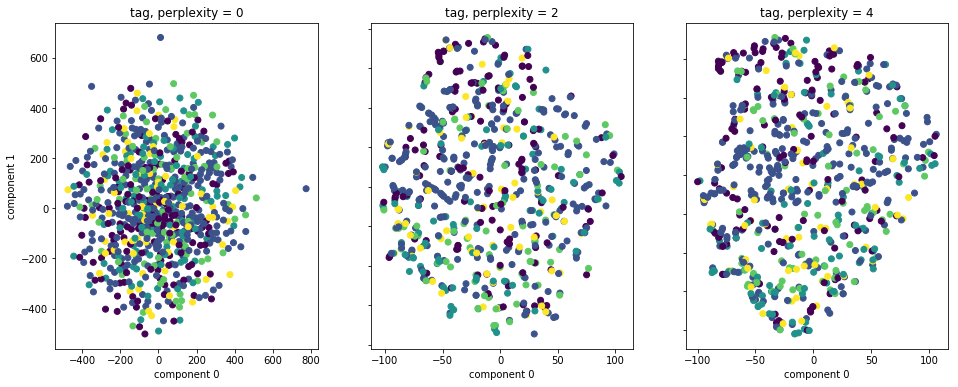

In [248]:
## item t-sne plots perplexity = 0,2,4

fig, axs = plt.subplots(1,3,figsize=(16,6))

for i, col in zip(perplexity3, range(3)):
    
    # fit/transform t-sne at different perplexity values
    arr_embedded = TSNE(n_components=2,perplexity=i,random_state=18).fit_transform(df_vt_samp)
    embedded_df = pd.DataFrame(arr_embedded,index=idx_vt_samp)
    embedded_df['track_index'] = embedded_df.index
    embedded_df = embedded_df.join(metadata_tag_df.set_index('track_index'),on='track_index')
    embedded_df = embedded_df.loc[~embedded_df.index.duplicated(keep='first')]
    embedded_df = embedded_df.dropna()
    
    embedded_df['tag'] = embedded_df['tag'].map({'pop':1, 'rock':2, 'electronic':3, 'indie':4, 'alternative':5})
    
    # tag t-sne plots at different perplexity values
    n = embedded_df['tag'].nunique()
    axs[col].scatter(x=embedded_df[0].values, y=embedded_df[1].values, c=embedded_df['tag'].values,label=embedded_df['tag'].unique())
    axs[col].set_title('tag, perplexity = {}'.format(i))


for ax in axs.flat:
    ax.set(xlabel='component 0', ylabel='component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

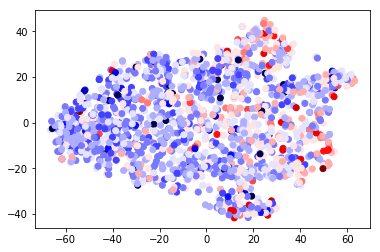

In [262]:
plt.figure(figsize=(6,4))

arr_embedded = TSNE(n_components=2,perplexity=i,random_state=12).fit_transform(df_vt_samp)
embedded_df = pd.DataFrame(arr_embedded,index=idx_vt_samp)
embedded_df['track_index'] = embedded_df.index
embedded_df = embedded_df.join(metadata_item_df.set_index('track_index'),on='track_index')
    
plt.scatter(x=embedded_df[0].values, y=embedded_df[1].values,
                        c=embedded_df['artist_hotttnesss'].values, cmap=plt.cm.get_cmap("seismic", 20))

plt.savefig('item_artist_hotness_25.png')